In [327]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
from glob import glob 
from PIL import Image
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [328]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

## Simple EDA

In [329]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Text(0.5, 1.0, 'Frequency Distribution of Classes')

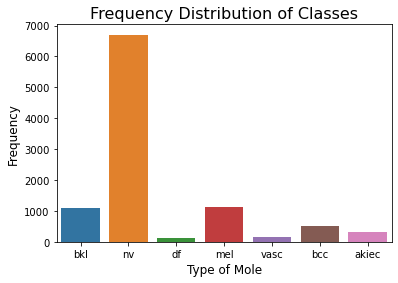

In [330]:
##Frequency distribution of classes:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [331]:
path = "HAM10000_images/"

In [332]:
df.shape

(10015, 7)

In [333]:
#Check for duplicates in dataset and remove them

bool_series = df['lesion_id'].duplicated()
bool_series.sum()

2545

In [334]:
#Removing duplicated 
df.drop_duplicates(subset ="lesion_id",
                     keep = "first", inplace = True)

In [335]:
df.shape

(7470, 7)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

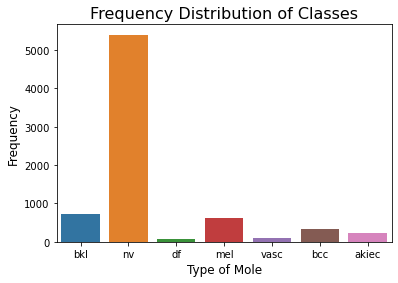

In [336]:
##Frequency distribution of classes after dropping duplicates:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [337]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]
y = X.pop('dx').to_frame()

In [338]:
X.sample(5)

,image_name,lesion_id
8497,ISIC_0028715.jpg,HAM_0002053
4525,ISIC_0026461.jpg,HAM_0007523
4361,ISIC_0031089.jpg,HAM_0003467
1377,ISIC_0031189.jpg,HAM_0006214
3750,ISIC_0032266.jpg,HAM_0002289


In [339]:
y.value_counts()

dx   
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
dtype: int64

### Oversampling for imbalanced dataset

In [340]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
#sampling_strategy = {'bkl': 600, 'nv':2000 , 'df': 73, 'mel':500 , 'vasc':98 , 'bcc':327 , 'akiec':228 }
#undersample = RandomUnderSampler(sampling_strategy='majority')
#undersample = RandomUnderSampler(sampling_strategy= sampling_strategy)
oversample = RandomOverSampler(sampling_strategy='minority')
X,y  = oversample.fit_resample(X,y)
#X,y = undersample.fit_resample(X,y)

In [341]:
X.shape

(12800, 2)

In [342]:
X.value_counts()

image_name        lesion_id  
ISIC_0026471.jpg  HAM_0006787    94
ISIC_0031123.jpg  HAM_0003487    92
ISIC_0029967.jpg  HAM_0004960    89
ISIC_0029177.jpg  HAM_0005918    87
ISIC_0027141.jpg  HAM_0000024    85
                                 ..
ISIC_0027402.jpg  HAM_0006556     1
ISIC_0027401.jpg  HAM_0007046     1
ISIC_0027400.jpg  HAM_0002062     1
ISIC_0027399.jpg  HAM_0000935     1
ISIC_0034320.jpg  HAM_0002244     1
Length: 7470, dtype: int64

In [343]:
y.shape

(12800, 1)

In [344]:
y.value_counts()

dx   
df       5403
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of Classes')

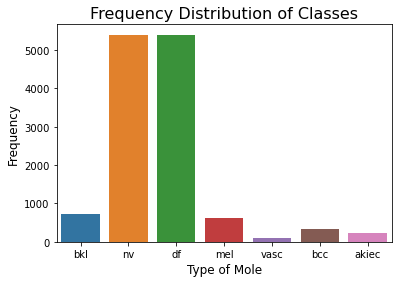

In [345]:
sns.countplot(x = 'dx', data = y)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [346]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw, https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [348]:
train.head()

,image_name,lesion_id,dx
3780,ISIC_0028742.jpg,HAM_0004062,nv
4646,ISIC_0025764.jpg,HAM_0003270,nv
3460,ISIC_0028729.jpg,HAM_0006989,nv
10335,ISIC_0031271.jpg,HAM_0004090,df
3455,ISIC_0024939.jpg,HAM_0000074,nv


In [349]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [350]:
val.head()

,image_name,lesion_id,dx,label
5446,ISIC_0026061.jpg,HAM_0001973,nv,5
12747,ISIC_0031271.jpg,HAM_0004090,df,3
3892,ISIC_0029586.jpg,HAM_0003864,nv,5
7908,ISIC_0033695.jpg,HAM_0000349,df,3
6278,ISIC_0032021.jpg,HAM_0000335,nv,5


In [352]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [391]:
test.head()

,image_name,lesion_id,dx,label
5173,ISIC_0028300.jpg,HAM_0004092,nv,5
9590,ISIC_0028651.jpg,HAM_0004496,df,3
1355,ISIC_0027560.jpg,HAM_0003885,mel,4
6114,ISIC_0034069.jpg,HAM_0003441,nv,5
3519,ISIC_0024719.jpg,HAM_0007154,nv,5


In [353]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00
)
#train_generator = ImageDataGenerator(rescale = 1./255)

In [354]:
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224), subset="training")
#train_generator.fit(X_train)

Found 8192 validated image filenames belonging to 7 classes.


In [355]:
train_data.image_shape

(224, 224, 3)

In [404]:
test_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.02
)


In [400]:
test_data = test_generator.flow_from_dataframe(dataframe=test, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 2560 validated image filenames belonging to 7 classes.


In [401]:
test_data.image_shape

(224, 224, 3)

In [402]:
test_data

In [360]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=True, class_mode="categorical", target_size=(224,224))

Found 2048 validated image filenames belonging to 7 classes.


In [361]:
val_data.image_shape

(224, 224, 3)

### Showcase some of the training images

In [362]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

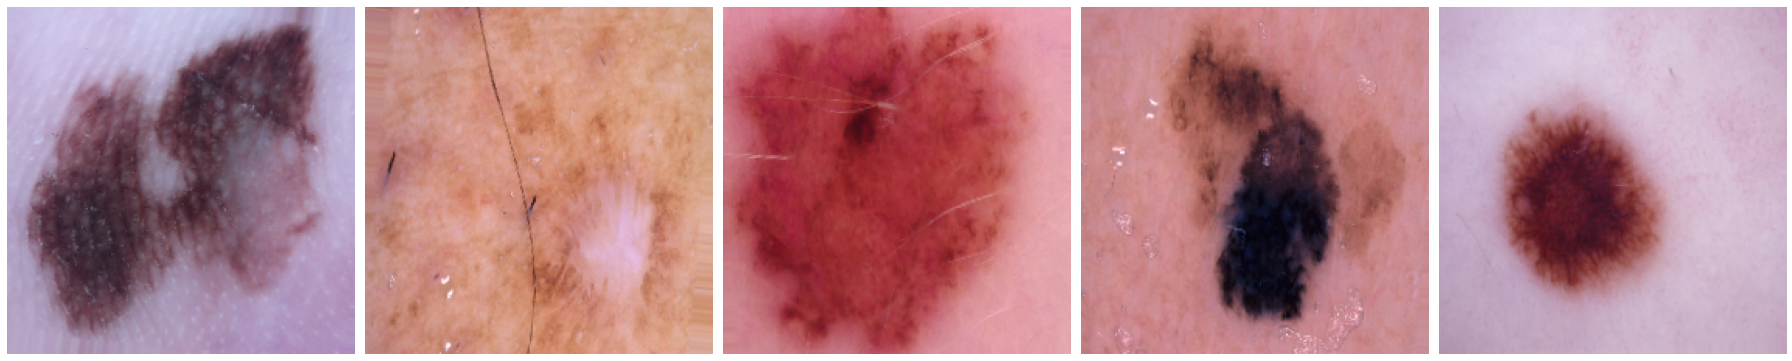

In [363]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [364]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))


In [365]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [366]:
#Reference https://www.kaggle.com/code/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe/notebook
# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
# Save the best model during the traning
checkpointer = ModelCheckpoint('./model/best_model1.h5'
                                        ,monitor='val_accuracy'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
history1 = History()

In [367]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [368]:
#Defining metrics
# METRICS = [
#       metrics.TruePositives(name='tp'),
#       metrics.FalsePositives(name='fp'),
#       metrics.TrueNegatives(name='tn'),
#       metrics.FalseNegatives(name='fn'), 
#       metrics.CategoricalAccuracy(name='accuracy'),
#       metrics.CategoricalAccuracy(name='val_acc'),
#       metrics.Precision(name='precision'),
#       metrics.Recall(name='recall'),
#       metrics.AUC(name='auc'),
#       metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

In [369]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])

In [370]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 16)          0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [371]:
history=model.fit(train_data,batch_size=128, epochs=5, validation_data=val_data ,callbacks=[earlystopper, checkpointer, reduce_lr, history1])

# Get the best saved weights
#model.load_weights('./model/best_model1.h5')

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.7329
Epoch 1: val_accuracy improved from -inf to 0.40967, saving model to ./model\best_model1.h5
256/256 [==============================] - 1093s 4s/step - loss: 0.8412 - accuracy: 0.7329 - val_loss: 3.8977 - val_accuracy: 0.4097 - lr: 0.0100
Epoch 2/5
256/256 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.8303
Epoch 2: val_accuracy did not improve from 0.40967
256/256 [==============================] - 1126s 4s/step - loss: 0.5133 - accuracy: 0.8303 - val_loss: 7.9790 - val_accuracy: 0.4053 - lr: 0.0100
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8403
Epoch 3: val_accuracy improved from 0.40967 to 0.49414, saving model to ./model\best_model1.h5
256/256 [==============================] - 1106s 4s/step - loss: 0.4366 - accuracy: 0.8403 - val_loss: 5.9818 - val_accuracy: 0.4941 - lr: 0.0100
Epoch 4/5
256/256 [====================

In [373]:
#Get the best saved weights
model.load_weights('./model/best_model1.h5')

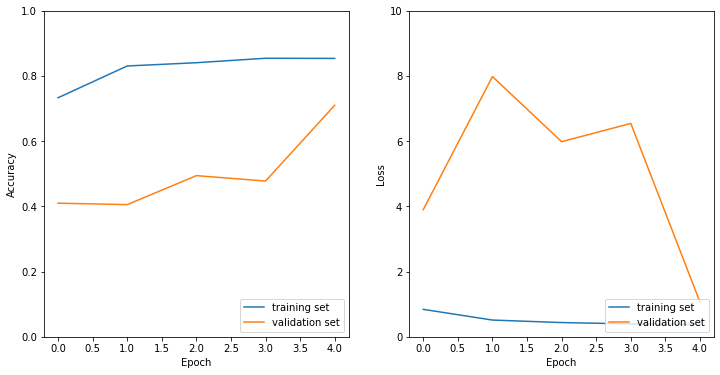

In [374]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    #plt.title("Model Accuracy")
    #axs[0].plt.title('Model Accuracy')
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])
    
    #plt.title("Model Loss")
    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [403]:
#loss, acc = model.evaluate(test_data, verbose=0)
model.evaluate(test_data, verbose=2)
# print('Test accuracy: ', score)
# print('Test loss:', loss)
# print('Test accuracy:', acc)

40/40 - 75s - loss: 0.9931 - accuracy: 0.7133 - 75s/epoch - 2s/step


[0.9930764436721802, 0.7132812738418579]

In [376]:
loss, acc = model.evaluate(val_data, verbose=2)
print('Validation loss:', loss)
print('Validation accuracy:', acc)

32/32 - 79s - loss: 1.0403 - accuracy: 0.7134 - 79s/epoch - 2s/step
Validation loss: 1.0402988195419312
Validation accuracy: 0.71337890625


In [377]:
history.history

{'loss': [0.8411874771118164,
  0.5132941007614136,
  0.4366419017314911,
  0.39537256956100464,
  0.38365259766578674],
 'accuracy': [0.73291015625,
  0.830322265625,
  0.84033203125,
  0.85400390625,
  0.853515625],
 'val_loss': [3.8977394104003906,
  7.979016304016113,
  5.9817938804626465,
  6.542237281799316,
  1.0642186403274536],
 'val_accuracy': [0.40966796875,
  0.4052734375,
  0.494140625,
  0.4775390625,
  0.7099609375],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01]}

In [378]:
print('Loss is ' + str(history.history['loss'][4]))

Loss is 0.38365259766578674


In [379]:
print('Accuracy is ' + str(history.history['accuracy'][4]))

Accuracy is 0.853515625


In [381]:
#print('Precision is ' + str(history.history['precision'][4]))

In [383]:
#print('Recall is ' + str(history.history['recall'][4]))

In [384]:
model.save('./model/my_model.h5')

In [385]:
# Dictionary with different classes of moles:
#Reference: https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

### Predicting Class Type

ISIC_0031983.jpg


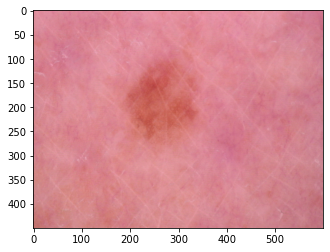

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0029323.jpg


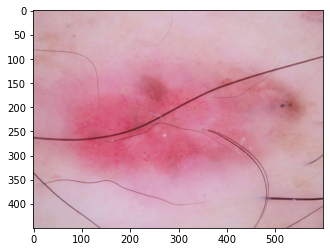

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0024667.jpg


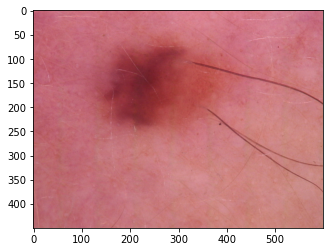

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027157.jpg


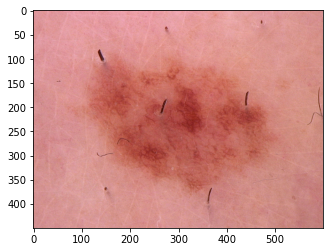

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0032774.jpg


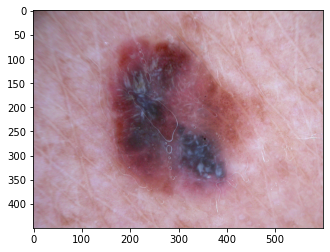

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027178.jpg


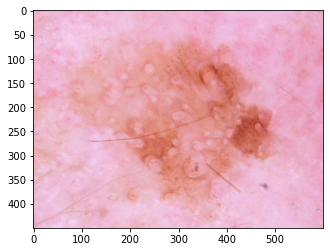

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0029014.jpg


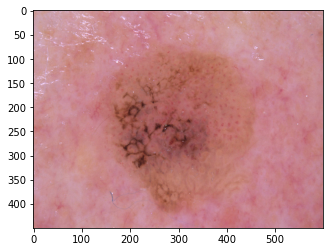

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0033847.jpg


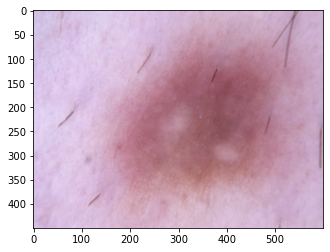

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0031604.jpg


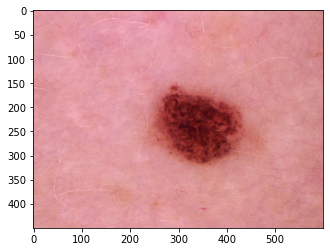

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0029457.jpg


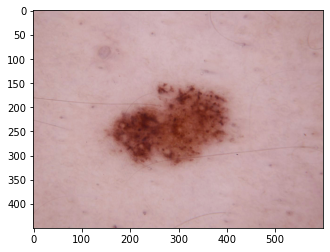

('bkl', 'benign keratosis-like lesions')


In [390]:

for temp in range(0,10):
    img_name = random.choice(os.listdir(path))
    print(img_name)
    img = cv2.imread(os.path.join(path, img_name))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.resize(img, (224, 224))
    result = model.predict(img.reshape(1, 224, 224, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    